<a href="https://colab.research.google.com/github/adsferreira/yolov3.opencv.tutorial/blob/main/yolov3_opencv_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detectando objetos em imagens e vídeos com YOLOv3 e OpenCV**

Neste minicurso, aprenderemos a utilizar o YOLOv3 e o OpenCV para detectar objetos em imagens e vídeos. O YOLOv3 é um detector de objetos, baseado em redes neurais, que processa imagens para detectar uma quantidade delimitada de objetos. Neste tutorial, empregaremos o YOLOv3 treinado na base de dados COCO (ref), que conta com 80 objetos diferentes. Para abrir as imagens e vídeos e gerar delimitadores visuais dos objetos identificados, utilizaremos a biblioteca *Open Computer Vision* (OpenCV), uma biblioteca otimizada de código aberto para visão computacional. As soluções aqui apresentadas serão desenvolvidas em linguaguem de programação Python.

### **1. Contexto para utilização do YOLO?**


Suponha que um determinado cliente contate sua empresa desenvolvedora de softwares para solicitar um programa que processe imagens e vídeos para não somente dizer que há determinados objetos nestes, mas também onde estão estes objetos.

Um exemplo do funcionamento deste programa é dado abaixo. Uma imagem que ilustra um elefante, zebras, e entre outros animais é processada por um programa que gera, como respota, a deteçção, delimitação, rotulação, e a probabilidade estimada de que aquele rótulo pertence ao respectivo objeto.

Imagem original: 

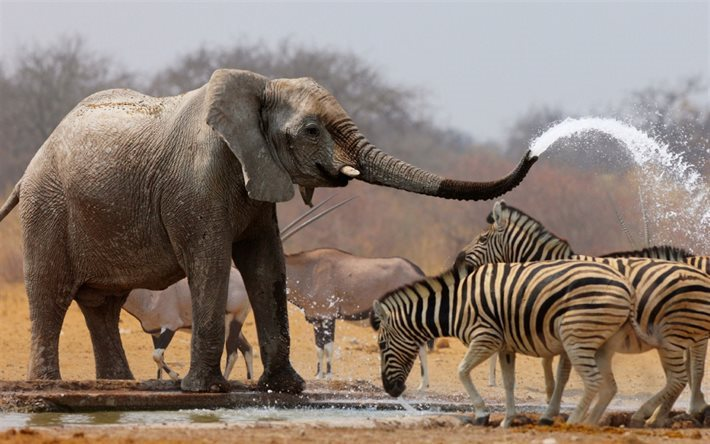

Imagem com objetos detectados:

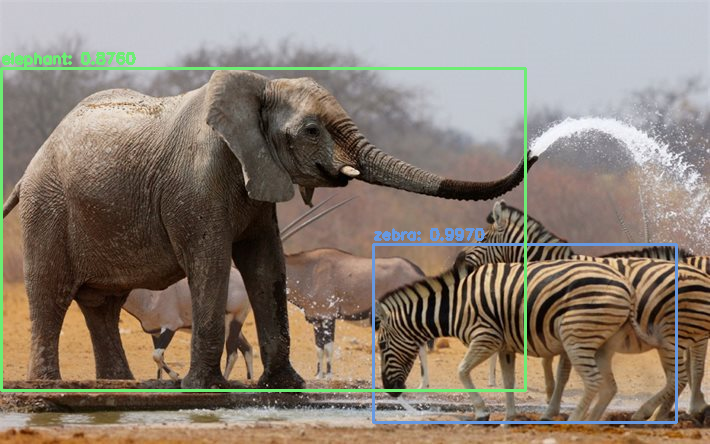

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] loading YOLO from disk...
[INFO] YOLO took 2.688555 seconds


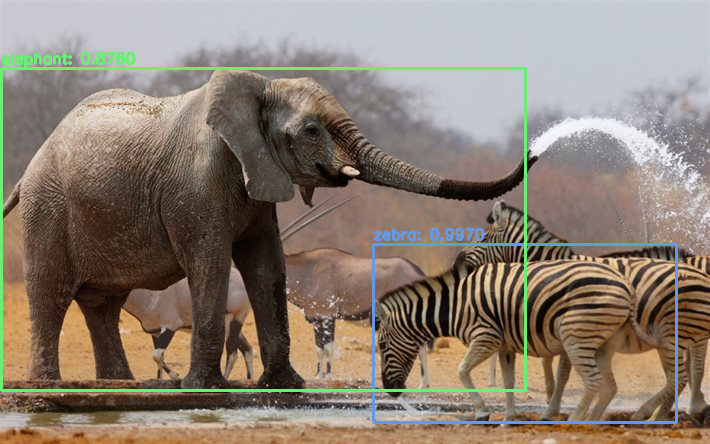

-1

In [ ]:
import numpy as np
import argparse
import time
import cv2
import os
from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="path to input image")
ap.add_argument("-y", "--yolo", required=True, help="base path to YOLO directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
ap.add_argument("-t", "--threshold", type=float, default=0.3,
	help="threshold when applying non-maxima suppression")
args = vars(ap.parse_args(['--image',
                           '/content/drive/MyDrive/minicurso_yolo_opencv/images/africa-elephant-zebra-river-savannah.jpg',
													 '--yolo',
													 '/content/drive/MyDrive/minicurso_yolo_opencv/yolo-coco']))

# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# load our input image and grab its spatial dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > args["confidence"]:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)
   
   # apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
	args["threshold"])

# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from google.colab import drive

drive.mount('/content/drive')
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=True,
	help="path to input video")
ap.add_argument("-o", "--output", required=True,
	help="path to output video")
ap.add_argument("-y", "--yolo", required=True,
	help="base path to YOLO directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
ap.add_argument("-t", "--threshold", type=float, default=0.3,
	help="threshold when applyong non-maxima suppression")
args = vars(ap.parse_args(['--input',
                           '/content/drive/MyDrive/minicurso_yolo_opencv/videos/ski.mp4',
                           '--output',
                           '/content/drive/MyDrive/minicurso_yolo_opencv/output/ski.avi',
													 '--yolo',
													 '/content/drive/MyDrive/minicurso_yolo_opencv/yolo-coco']))

# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
writer = None
(W, H) = (None, None)
# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()
	# initialize our lists of detected bounding boxes, confidences,
	# and class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]
			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > args["confidence"]:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")
				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				# update our list of bounding box coordinates,
				# confidences, and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)
    
	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
		args["threshold"])
	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])
			# draw a bounding box rectangle and label on the frame
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]],
				confidences[i])
			cv2.putText(frame, text, (x, y - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
   
	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(frame.shape[1], frame.shape[0]), True)
		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time to finish: {:.4f}".format(
				elap * total))
	# write the output frame to disk
	writer.write(frame)
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] loading YOLO from disk...
[INFO] 375 total frames in video
[INFO] single frame took 1.5913 seconds
[INFO] estimated total time to finish: 596.7203
[INFO] cleaning up...
